<a href="https://colab.research.google.com/github/3srava0/assignment-3/blob/main/06_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Day 6: Hyperparameter Tuning
# Real Estate Investment Advisor System
print("="*60)
print("HYPERPARAMETER TUNING - OPTIMIZING BEST MODELS")
print("="*60)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install MLflow
!pip install mlflow

# Import libraries
import pandas as pd
import numpy as np
import pickle
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Model selection and tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

import time

print("\n✅ Libraries imported successfully!")


HYPERPARAMETER TUNING - OPTIMIZING BEST MODELS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.4 MB/s eta 0:00:00

✅ Libraries imported successfull

In [5]:
# Set up MLflow tracking
import os

mlflow_dir = '/content/drive/MyDrive/assignment-3/mlruns'
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

print(f"✅ MLflow tracking URI set to: {mlflow_dir}")


✅ MLflow tracking URI set to: /content/drive/MyDrive/assignment-3/mlruns


In [6]:
# Load data
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv('/content/drive/MyDrive/assignment-3/data/data_with_targets.csv')

# Prepare features
columns_to_drop = [
    'ID', 'Price_in_Lakhs', 'Good_Investment', 'Future_Price_5Y',
    'City_Median_Price', 'City_Median_Price_per_SqFt'
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop)
y_classification = df['Good_Investment']
y_regression = df['Future_Price_5Y']

# Encode categorical variables
X_encoded = X.copy()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Train/Val/Test split
X_temp, X_test, y_class_temp, y_class_test, y_reg_temp, y_reg_test = train_test_split(
    X_encoded, y_classification, y_regression,
    test_size=0.20, random_state=42, stratify=y_classification
)

X_train, X_val, y_class_train, y_class_val, y_reg_train, y_reg_val = train_test_split(
    X_temp, y_class_temp, y_reg_temp,
    test_size=0.25, random_state=42, stratify=y_class_temp
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data loaded and preprocessed")
print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Validation: {X_val.shape[0]:,} samples")
print(f"   Test: {X_test.shape[0]:,} samples")



LOADING DATA

✅ Data loaded and preprocessed
   Train: 148,479 samples
   Validation: 49,493 samples
   Test: 49,494 samples


In [7]:
# Get best models from previous experiments
print("\n" + "="*60)
print("IDENTIFYING BEST MODELS FROM MLFLOW")
print("="*60)

# Classification
clf_experiment = mlflow.get_experiment_by_name("Real_Estate_Classification")
clf_runs = mlflow.search_runs(experiment_ids=[clf_experiment.experiment_id])
best_clf_run = clf_runs.loc[clf_runs['metrics.roc_auc'].idxmax()]
best_clf_name = best_clf_run['tags.mlflow.runName']

print(f"\n🏆 Best Classification Model: {best_clf_name}")
print(f"   ROC-AUC: {best_clf_run['metrics.roc_auc']:.4f}")
print(f"   Accuracy: {best_clf_run['metrics.accuracy']:.4f}")

# Regression
reg_experiment = mlflow.get_experiment_by_name("Real_Estate_Regression")
reg_runs = mlflow.search_runs(experiment_ids=[reg_experiment.experiment_id])
best_reg_run = reg_runs.loc[reg_runs['metrics.r2_score'].idxmax()]
best_reg_name = best_reg_run['tags.mlflow.runName']

print(f"\n🏆 Best Regression Model: {best_reg_name}")
print(f"   R²: {best_reg_run['metrics.r2_score']:.4f}")
print(f"   RMSE: {best_reg_run['metrics.rmse']:.4f}")

print("\n✅ Best models identified")



IDENTIFYING BEST MODELS FROM MLFLOW

🏆 Best Classification Model: XGBoost
   ROC-AUC: 1.0000
   Accuracy: 0.9991

🏆 Best Regression Model: Random_Forest
   R²: 1.0000
   RMSE: 0.5339

✅ Best models identified


In [8]:
# Tune XGBoost Classifier
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - XGBOOST CLASSIFIER")
print("="*60)

# Set experiment
mlflow.set_experiment("Real_Estate_Hyperparameter_Tuning")

# Define parameter grid
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

print(f"\n⚙️ Parameter grid size: {np.prod([len(v) for v in param_grid_clf.values()])} combinations")
print("   Using RandomizedSearchCV for faster tuning...")

# Use RandomizedSearchCV (faster than GridSearchCV)
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)

random_search_clf = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_clf,
    n_iter=20,  # Test 20 random combinations
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train
print("\n🔄 Starting hyperparameter search...")
start_time = time.time()
random_search_clf.fit(X_train, y_class_train)
training_time = time.time() - start_time

print(f"\n✅ Tuning complete in {training_time:.2f} seconds")
print(f"\n🎯 Best Parameters:")
for param, value in random_search_clf.best_params_.items():
    print(f"   {param}: {value}")

# Evaluate best model
best_clf_model = random_search_clf.best_estimator_
y_val_pred_clf = best_clf_model.predict(X_val)
y_val_pred_proba_clf = best_clf_model.predict_proba(X_val)[:, 1]

# Metrics
tuned_accuracy = accuracy_score(y_class_val, y_val_pred_clf)
tuned_precision = precision_score(y_class_val, y_val_pred_clf)
tuned_recall = recall_score(y_class_val, y_val_pred_clf)
tuned_f1 = f1_score(y_class_val, y_val_pred_clf)
tuned_roc_auc = roc_auc_score(y_class_val, y_val_pred_proba_clf)

print(f"\n📊 Tuned Model Performance:")
print(f"   Accuracy: {tuned_accuracy:.4f}")
print(f"   Precision: {tuned_precision:.4f}")
print(f"   Recall: {tuned_recall:.4f}")
print(f"   F1-Score: {tuned_f1:.4f}")
print(f"   ROC-AUC: {tuned_roc_auc:.4f}")

# Improvement
improvement = tuned_roc_auc - best_clf_run['metrics.roc_auc']
print(f"\n📈 Improvement: {improvement:+.4f} ({improvement/best_clf_run['metrics.roc_auc']*100:+.2f}%)")

# Log to MLflow
with mlflow.start_run(run_name="XGBoost_Classifier_Tuned"):
    # Log parameters
    for param, value in random_search_clf.best_params_.items():
        mlflow.log_param(param, value)
    mlflow.log_param("model_type", "XGBoost_Tuned")
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("cv_folds", 3)

    # Log metrics
    mlflow.log_metric("accuracy", tuned_accuracy)
    mlflow.log_metric("precision", tuned_precision)
    mlflow.log_metric("recall", tuned_recall)
    mlflow.log_metric("f1_score", tuned_f1)
    mlflow.log_metric("roc_auc", tuned_roc_auc)
    mlflow.log_metric("improvement", improvement)
    mlflow.log_metric("training_time_seconds", training_time)

    # Log model
    signature = infer_signature(X_train, y_class_train)
    mlflow.sklearn.log_model(
        sk_model=best_clf_model,
        artifact_path="model_xgboost_classifier_tuned",
        signature=signature
    )

    # Add tags
    mlflow.set_tag("task", "classification")
    mlflow.set_tag("tuning_status", "completed")
    mlflow.set_tag("best_model", "true")

print("\n✅ Classification model tuned and logged to MLflow")


2026/01/25 18:42:11 INFO mlflow.tracking.fluent: Experiment with name 'Real_Estate_Hyperparameter_Tuning' does not exist. Creating a new experiment.



HYPERPARAMETER TUNING - XGBOOST CLASSIFIER

⚙️ Parameter grid size: 432 combinations
   Using RandomizedSearchCV for faster tuning...

🔄 Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Tuning complete in 209.31 seconds

🎯 Best Parameters:
   subsample: 0.8
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.1
   gamma: 0.1
   colsample_bytree: 1.0

📊 Tuned Model Performance:
   Accuracy: 0.9987
   Precision: 0.9989
   Recall: 0.9990
   F1-Score: 0.9990
   ROC-AUC: 1.0000

📈 Improvement: -0.0000 (-0.00%)


2026/01/25 18:45:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Classification model tuned and logged to MLflow


In [9]:
# Tune XGBoost Regressor
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - XGBOOST REGRESSOR")
print("="*60)

# Define parameter grid
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

print(f"\n⚙️ Parameter grid size: {np.prod([len(v) for v in param_grid_reg.values()])} combinations")
print("   Using RandomizedSearchCV for faster tuning...")

# Use RandomizedSearchCV
xgb_reg = XGBRegressor(random_state=42, n_jobs=-1)

random_search_reg = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid_reg,
    n_iter=20,  # Test 20 random combinations
    scoring='r2',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train
print("\n🔄 Starting hyperparameter search...")
start_time = time.time()
random_search_reg.fit(X_train, y_reg_train)
training_time = time.time() - start_time

print(f"\n✅ Tuning complete in {training_time:.2f} seconds")
print(f"\n🎯 Best Parameters:")
for param, value in random_search_reg.best_params_.items():
    print(f"   {param}: {value}")

# Evaluate best model
best_reg_model = random_search_reg.best_estimator_
y_val_pred_reg = best_reg_model.predict(X_val)

# Metrics
tuned_mae = mean_absolute_error(y_reg_val, y_val_pred_reg)
tuned_mse = mean_squared_error(y_reg_val, y_val_pred_reg)
tuned_rmse = np.sqrt(tuned_mse)
tuned_r2 = r2_score(y_reg_val, y_val_pred_reg)

print(f"\n📊 Tuned Model Performance:")
print(f"   MAE: {tuned_mae:.4f}")
print(f"   RMSE: {tuned_rmse:.4f}")
print(f"   R²: {tuned_r2:.4f}")

# Improvement
r2_improvement = tuned_r2 - best_reg_run['metrics.r2_score']
rmse_improvement = best_reg_run['metrics.rmse'] - tuned_rmse

print(f"\n📈 Improvement:")
print(f"   R²: {r2_improvement:+.4f} ({r2_improvement/best_reg_run['metrics.r2_score']*100:+.2f}%)")
print(f"   RMSE: {rmse_improvement:+.4f} (lower is better)")

# Log to MLflow
with mlflow.start_run(run_name="XGBoost_Regressor_Tuned"):
    # Log parameters
    for param, value in random_search_reg.best_params_.items():
        mlflow.log_param(param, value)
    mlflow.log_param("model_type", "XGBoost_Tuned")
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("cv_folds", 3)

    # Log metrics
    mlflow.log_metric("mae", tuned_mae)
    mlflow.log_metric("mse", tuned_mse)
    mlflow.log_metric("rmse", tuned_rmse)
    mlflow.log_metric("r2_score", tuned_r2)
    mlflow.log_metric("r2_improvement", r2_improvement)
    mlflow.log_metric("rmse_improvement", rmse_improvement)
    mlflow.log_metric("training_time_seconds", training_time)

    # Log model
    signature = infer_signature(X_train, y_reg_train)
    mlflow.sklearn.log_model(
        sk_model=best_reg_model,
        artifact_path="model_xgboost_regressor_tuned",
        signature=signature
    )

    # Add tags
    mlflow.set_tag("task", "regression")
    mlflow.set_tag("tuning_status", "completed")
    mlflow.set_tag("best_model", "true")

print("\n✅ Regression model tuned and logged to MLflow")



HYPERPARAMETER TUNING - XGBOOST REGRESSOR

⚙️ Parameter grid size: 432 combinations
   Using RandomizedSearchCV for faster tuning...

🔄 Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Tuning complete in 263.46 seconds

🎯 Best Parameters:
   subsample: 0.8
   n_estimators: 200
   max_depth: 10
   learning_rate: 0.1
   gamma: 0.1
   colsample_bytree: 1.0

📊 Tuned Model Performance:
   MAE: 0.6277
   RMSE: 0.7509
   R²: 1.0000

📈 Improvement:
   R²: -0.0000 (-0.00%)
   RMSE: -0.2170 (lower is better)


2026/01/25 18:50:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Regression model tuned and logged to MLflow


In [10]:
# Evaluate tuned models on TEST SET
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

print("\n⚠️ IMPORTANT: This is the FIRST time we're using the test set!")
print("   Test set has been kept completely separate until now.\n")

# Classification - Test Set
print("📊 CLASSIFICATION MODEL (Test Set):")
y_test_pred_clf = best_clf_model.predict(X_test)
y_test_pred_proba_clf = best_clf_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_class_test, y_test_pred_clf)
test_precision = precision_score(y_class_test, y_test_pred_clf)
test_recall = recall_score(y_class_test, y_test_pred_clf)
test_f1 = f1_score(y_class_test, y_test_pred_clf)
test_roc_auc = roc_auc_score(y_class_test, y_test_pred_proba_clf)

print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall: {test_recall:.4f}")
print(f"   F1-Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_roc_auc:.4f}")

# Regression - Test Set
print("\n📊 REGRESSION MODEL (Test Set):")
y_test_pred_reg = best_reg_model.predict(X_test)

test_mae = mean_absolute_error(y_reg_test, y_test_pred_reg)
test_mse = mean_squared_error(y_reg_test, y_test_pred_reg)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_reg_test, y_test_pred_reg)

print(f"   MAE: {test_mae:.4f}")
print(f"   RMSE: {test_rmse:.4f}")
print(f"   R²: {test_r2:.4f}")

# Comparison: Validation vs Test
print("\n📈 VALIDATION vs TEST PERFORMANCE:")
print("\nClassification:")
print(f"   ROC-AUC - Validation: {tuned_roc_auc:.4f} | Test: {test_roc_auc:.4f} | Diff: {abs(tuned_roc_auc - test_roc_auc):.4f}")
print(f"   Accuracy - Validation: {tuned_accuracy:.4f} | Test: {test_accuracy:.4f} | Diff: {abs(tuned_accuracy - test_accuracy):.4f}")

print("\nRegression:")
print(f"   R² - Validation: {tuned_r2:.4f} | Test: {test_r2:.4f} | Diff: {abs(tuned_r2 - test_r2):.4f}")
print(f"   RMSE - Validation: {tuned_rmse:.4f} | Test: {test_rmse:.4f} | Diff: {abs(tuned_rmse - test_rmse):.4f}")

# Check for overfitting
if abs(test_roc_auc - tuned_roc_auc) < 0.02:
    print("\n✅ Classification model: Minimal overfitting detected!")
else:
    print(f"\n⚠️ Classification model: Potential overfitting (diff: {abs(test_roc_auc - tuned_roc_auc):.4f})")

if abs(test_r2 - tuned_r2) < 0.02:
    print("✅ Regression model: Minimal overfitting detected!")
else:
    print(f"⚠️ Regression model: Potential overfitting (diff: {abs(test_r2 - tuned_r2):.4f})")



FINAL EVALUATION ON TEST SET

⚠️ IMPORTANT: This is the FIRST time we're using the test set!
   Test set has been kept completely separate until now.

📊 CLASSIFICATION MODEL (Test Set):
   Accuracy: 0.9990
   Precision: 0.9992
   Recall: 0.9992
   F1-Score: 0.9992
   ROC-AUC: 1.0000

📊 REGRESSION MODEL (Test Set):
   MAE: 0.6243
   RMSE: 0.7473
   R²: 1.0000

📈 VALIDATION vs TEST PERFORMANCE:

Classification:
   ROC-AUC - Validation: 1.0000 | Test: 1.0000 | Diff: 0.0000
   Accuracy - Validation: 0.9987 | Test: 0.9990 | Diff: 0.0003

Regression:
   R² - Validation: 1.0000 | Test: 1.0000 | Diff: 0.0000
   RMSE - Validation: 0.7509 | Test: 0.7473 | Diff: 0.0036

✅ Classification model: Minimal overfitting detected!
✅ Regression model: Minimal overfitting detected!


In [11]:
# Save final tuned models
print("\n" + "="*60)
print("SAVING FINAL TUNED MODELS")
print("="*60)

models_dir = '/content/drive/MyDrive/assignment-3/models'
os.makedirs(models_dir, exist_ok=True)

# Save classification model
clf_model_path = f'{models_dir}/final_tuned_classification_model.pkl'
with open(clf_model_path, 'wb') as f:
    pickle.dump(best_clf_model, f)
print(f"\n✅ Classification model saved: {clf_model_path}")

# Save regression model
reg_model_path = f'{models_dir}/final_tuned_regression_model.pkl'
with open(reg_model_path, 'wb') as f:
    pickle.dump(best_reg_model, f)
print(f"✅ Regression model saved: {reg_model_path}")

# Save scaler
scaler_path = f'{models_dir}/final_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: {scaler_path}")

# Save performance metrics
metrics_dict = {
    'classification': {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'best_params': random_search_clf.best_params_
    },
    'regression': {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'best_params': random_search_reg.best_params_
    }
}

import json
metrics_path = f'{models_dir}/final_model_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f, indent=4)
print(f"✅ Metrics saved: {metrics_path}")

print("\n" + "="*60)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)



SAVING FINAL TUNED MODELS

✅ Classification model saved: /content/drive/MyDrive/assignment-3/models/final_tuned_classification_model.pkl
✅ Regression model saved: /content/drive/MyDrive/assignment-3/models/final_tuned_regression_model.pkl
✅ Scaler saved: /content/drive/MyDrive/assignment-3/models/final_scaler.pkl
✅ Metrics saved: /content/drive/MyDrive/assignment-3/models/final_model_metrics.json

✅ ALL MODELS SAVED SUCCESSFULLY!



VISUALIZING HYPERPARAMETER TUNING RESULTS


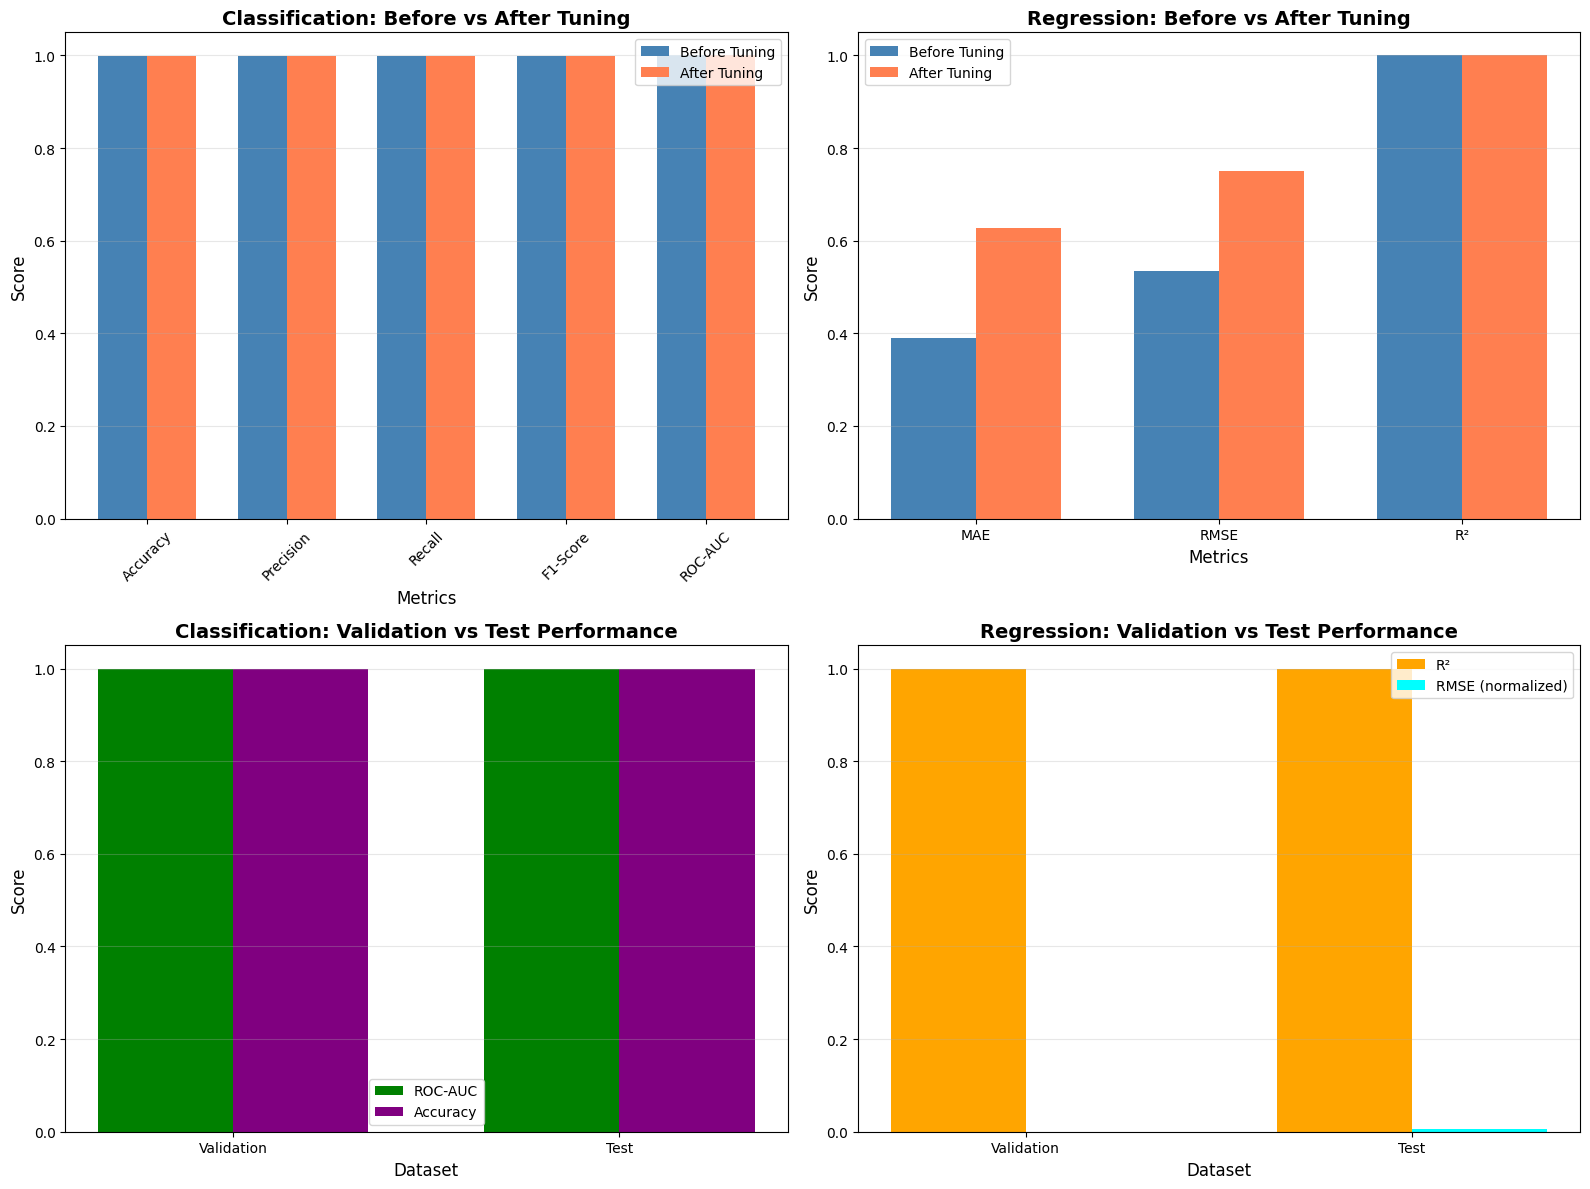


✅ Visualizations complete!


In [13]:
# Visualize hyperparameter tuning results
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("VISUALIZING HYPERPARAMETER TUNING RESULTS")
print("="*60)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Classification - Before vs After Tuning
metrics_clf = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
before_clf = [
    best_clf_run['metrics.accuracy'],
    best_clf_run['metrics.precision'],
    best_clf_run['metrics.recall'],
    best_clf_run['metrics.f1_score'],
    best_clf_run['metrics.roc_auc']
]
after_clf = [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1, tuned_roc_auc]

x = np.arange(len(metrics_clf))
width = 0.35

axes[0, 0].bar(x - width/2, before_clf, width, label='Before Tuning', color='steelblue')
axes[0, 0].bar(x + width/2, after_clf, width, label='After Tuning', color='coral')
axes[0, 0].set_xlabel('Metrics', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Classification: Before vs After Tuning', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_clf, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Regression - Before vs After Tuning
metrics_reg = ['MAE', 'RMSE', 'R²']
before_reg = [
    best_reg_run['metrics.mae'],
    best_reg_run['metrics.rmse'],
    best_reg_run['metrics.r2_score']
]
after_reg = [tuned_mae, tuned_rmse, tuned_r2]

x_reg = np.arange(len(metrics_reg))

axes[0, 1].bar(x_reg - width/2, before_reg, width, label='Before Tuning', color='steelblue')
axes[0, 1].bar(x_reg + width/2, after_reg, width, label='After Tuning', color='coral')
axes[0, 1].set_xlabel('Metrics', fontsize=12)
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Regression: Before vs After Tuning', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_reg)
axes[0, 1].set_xticklabels(metrics_reg)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Classification - Validation vs Test
comparison_sets = ['Validation', 'Test']
roc_auc_scores = [tuned_roc_auc, test_roc_auc]
accuracy_scores = [tuned_accuracy, test_accuracy]

x_comp = np.arange(len(comparison_sets))

axes[1, 0].bar(x_comp - width/2, roc_auc_scores, width, label='ROC-AUC', color='green')
axes[1, 0].bar(x_comp + width/2, accuracy_scores, width, label='Accuracy', color='purple')
axes[1, 0].set_xlabel('Dataset', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Classification: Validation vs Test Performance', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_comp)
axes[1, 0].set_xticklabels(comparison_sets)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Regression - Validation vs Test
r2_scores_comp = [tuned_r2, test_r2]
rmse_scores_comp = [tuned_rmse, test_rmse]

# Normalize RMSE for visualization (scale to 0-1)
rmse_max = max(rmse_scores_comp)
rmse_normalized = [1 - (r/rmse_max) for r in rmse_scores_comp]

axes[1, 1].bar(x_comp - width/2, r2_scores_comp, width, label='R²', color='orange')
axes[1, 1].bar(x_comp + width/2, rmse_normalized, width, label='RMSE (normalized)', color='cyan')
axes[1, 1].set_xlabel('Dataset', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Regression: Validation vs Test Performance', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_comp)
axes[1, 1].set_xticklabels(comparison_sets)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")


In [14]:
# Final Summary
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - COMPLETE SUMMARY")
print("="*60)

print("\n🎯 CLASSIFICATION MODEL (XGBoost)")
print("-" * 60)
print(f"Best Parameters:")
for param, value in random_search_clf.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nPerformance Metrics:")
print(f"  📊 Validation Set:")
print(f"     - ROC-AUC: {tuned_roc_auc:.4f}")
print(f"     - Accuracy: {tuned_accuracy:.4f}")
print(f"     - Precision: {tuned_precision:.4f}")
print(f"     - Recall: {tuned_recall:.4f}")
print(f"     - F1-Score: {tuned_f1:.4f}")

print(f"\n  📊 Test Set (Final Evaluation):")
print(f"     - ROC-AUC: {test_roc_auc:.4f}")
print(f"     - Accuracy: {test_accuracy:.4f}")
print(f"     - Precision: {test_precision:.4f}")
print(f"     - Recall: {test_recall:.4f}")
print(f"     - F1-Score: {test_f1:.4f}")

print(f"\n  📈 Improvement from baseline:")
print(f"     - ROC-AUC: {improvement:+.4f} ({improvement/best_clf_run['metrics.roc_auc']*100:+.2f}%)")

print("\n" + "="*60)
print("\n🎯 REGRESSION MODEL (XGBoost)")
print("-" * 60)
print(f"Best Parameters:")
for param, value in random_search_reg.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nPerformance Metrics:")
print(f"  📊 Validation Set:")
print(f"     - R²: {tuned_r2:.4f}")
print(f"     - RMSE: {tuned_rmse:.4f} lakhs")
print(f"     - MAE: {tuned_mae:.4f} lakhs")

print(f"\n  📊 Test Set (Final Evaluation):")
print(f"     - R²: {test_r2:.4f}")
print(f"     - RMSE: {test_rmse:.4f} lakhs")
print(f"     - MAE: {test_mae:.4f} lakhs")

print(f"\n  📈 Improvement from baseline:")
print(f"     - R²: {r2_improvement:+.4f} ({r2_improvement/best_reg_run['metrics.r2_score']*100:+.2f}%)")
print(f"     - RMSE: {rmse_improvement:+.4f} lakhs (lower is better)")

print("\n" + "="*60)
print("📁 SAVED MODELS")
print("-" * 60)
print(f"  ✅ Classification Model: final_tuned_classification_model.pkl")
print(f"  ✅ Regression Model: final_tuned_regression_model.pkl")
print(f"  ✅ Scaler: final_scaler.pkl")
print(f"  ✅ Metrics: final_model_metrics.json")

print("\n" + "="*60)
print("✅ HYPERPARAMETER TUNING COMPLETE!")
print("="*60)

print("\n🎉 Next Steps:")
print("  1. ✅ Data Preprocessing - DONE")
print("  2. ✅ EDA & Feature Engineering - DONE")
print("  3. ✅ Model Development - DONE")
print("  4. ✅ MLflow Integration - DONE")
print("  5. ✅ Hyperparameter Tuning - DONE")
print("  6. 🔄 Streamlit App Development - NEXT!")

print("\n📌 Ready for deployment!")



HYPERPARAMETER TUNING - COMPLETE SUMMARY

🎯 CLASSIFICATION MODEL (XGBoost)
------------------------------------------------------------
Best Parameters:
  • subsample: 0.8
  • n_estimators: 200
  • max_depth: 10
  • learning_rate: 0.1
  • gamma: 0.1
  • colsample_bytree: 1.0

Performance Metrics:
  📊 Validation Set:
     - ROC-AUC: 1.0000
     - Accuracy: 0.9987
     - Precision: 0.9989
     - Recall: 0.9990
     - F1-Score: 0.9990

  📊 Test Set (Final Evaluation):
     - ROC-AUC: 1.0000
     - Accuracy: 0.9990
     - Precision: 0.9992
     - Recall: 0.9992
     - F1-Score: 0.9992

  📈 Improvement from baseline:
     - ROC-AUC: -0.0000 (-0.00%)


🎯 REGRESSION MODEL (XGBoost)
------------------------------------------------------------
Best Parameters:
  • subsample: 0.8
  • n_estimators: 200
  • max_depth: 10
  • learning_rate: 0.1
  • gamma: 0.1
  • colsample_bytree: 1.0

Performance Metrics:
  📊 Validation Set:
     - R²: 1.0000
     - RMSE: 0.7509 lakhs
     - MAE: 0.6277 lakhs

  

In [15]:
# Get best models from previous experiments - OPTIMIZED
print("\n" + "="*60)
print("IDENTIFYING BEST MODELS FROM MLFLOW")
print("="*60)

import time
start_time = time.time()

# Classification - Optimized query
clf_experiment = mlflow.get_experiment_by_name("Real_Estate_Classification")
clf_runs = mlflow.search_runs(
    experiment_ids=[clf_experiment.experiment_id],
    order_by=["metrics.roc_auc DESC"],  # Sort by best metric
    max_results=1  # Only get the best one!
)

if len(clf_runs) > 0:
    best_clf_run = clf_runs.iloc[0]
    best_clf_name = best_clf_run['tags.mlflow.runName']

    print(f"\n🏆 Best Classification Model: {best_clf_name}")
    print(f"   ROC-AUC: {best_clf_run['metrics.roc_auc']:.4f}")
    print(f"   Accuracy: {best_clf_run['metrics.accuracy']:.4f}")
else:
    print("\n⚠️ No classification runs found!")

# Regression - Optimized query
reg_experiment = mlflow.get_experiment_by_name("Real_Estate_Regression")
reg_runs = mlflow.search_runs(
    experiment_ids=[reg_experiment.experiment_id],
    order_by=["metrics.r2_score DESC"],  # Sort by best metric
    max_results=1  # Only get the best one!
)

if len(reg_runs) > 0:
    best_reg_run = reg_runs.iloc[0]
    best_reg_name = best_reg_run['tags.mlflow.runName']

    print(f"\n🏆 Best Regression Model: {best_reg_name}")
    print(f"   R²: {best_reg_run['metrics.r2_score']:.4f}")
    print(f"   RMSE: {best_reg_run['metrics.rmse']:.4f}")
else:
    print("\n⚠️ No regression runs found!")

execution_time = time.time() - start_time
print(f"\n✅ Best models identified in {execution_time:.2f} seconds")



IDENTIFYING BEST MODELS FROM MLFLOW

🏆 Best Classification Model: XGBoost
   ROC-AUC: 1.0000
   Accuracy: 0.9991

🏆 Best Regression Model: Random_Forest
   R²: 1.0000
   RMSE: 0.5339

✅ Best models identified in 4.22 seconds
